# RN-A — Alineación astrométrica DP1 en 47 Tuc (Rubin×Gaia)

**Propósito.** Reproducir la figura y métricas de separaciones angulares para la RN-A a partir del parquet mínimo.

**Entradas.** `data/47tuc_dp1/rnA_matched_minimal.parquet`

**Salida.** `notebooks/47tuc/figs/rnA_hist_sep.png`

In [1]:
import os, sys, json
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
print('Versions: pandas', pd.__version__)

Versions: pandas 2.3.1


In [2]:
from pathlib import Path
import os, pandas as pd

def find_repo_root(start: Path = Path.cwd()) -> Path:
    p = start
    for _ in range(6):  # sube hasta 6 niveles por seguridad
        if (p / ".git").exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    return start  # fallback: cwd

ROOT = find_repo_root()
print("Repo root ->", ROOT)

# Rutas canónica y legacy
CANON = ROOT / "data/47tuc_dp1/rnA_matched_minimal.parquet"
LEGACY = ROOT / "notebooks/47tuc/data/47tuc_dp1/rnA_matched_minimal.parquet"

if CANON.exists():
    print("Usando canónica:", CANON)
    df = pd.read_parquet(CANON)
elif LEGACY.exists():
    print("Usando legacy:", LEGACY)
    df = pd.read_parquet(LEGACY)
    # copia a la ruta canónica para normalizar
    CANON.parent.mkdir(parents=True, exist_ok=True)
    df.to_parquet(CANON, index=False)
    print("Copiado a canónica ->", CANON)
else:
    raise FileNotFoundError(
        f"No encontré rnA_matched_minimal.parquet ni en {CANON} ni en {LEGACY}.\n"
        "Corre dp1_47tuc_prep.ipynb o verifica las rutas."
    )

# Normaliza columnas mínimas (por si los nombres difieren)
need = ["objectId","coord_ra","coord_dec","source_id","ra_gaia","dec_gaia","separation_arcsec"]
rename_map = {}
for c in df.columns:
    lc = c.lower()
    if c not in need:
        if lc in ["ra","ra_deg"] and "coord_ra" not in df.columns:
            rename_map[c] = "coord_ra"
        if lc in ["dec","dec_deg"] and "coord_dec" not in df.columns:
            rename_map[c] = "coord_dec"
        if lc.startswith("sep") and "arcsec" in lc and "separation_arcsec" not in df.columns:
            rename_map[c] = "separation_arcsec"

if rename_map:
    df = df.rename(columns=rename_map)

missing = [c for c in need if c not in df.columns]
if missing:
    raise ValueError(f"Faltan columnas requeridas: {missing}")

print("OK: df cargado con columnas:", list(df.columns))


Repo root -> /home/marcelor/portafolio-rubin
Usando canónica: /home/marcelor/portafolio-rubin/data/47tuc_dp1/rnA_matched_minimal.parquet
OK: df cargado con columnas: ['objectId', 'coord_ra', 'coord_dec', 'source_id', 'ra_gaia', 'dec_gaia', 'separation_arcsec']


In [3]:
# 1) Filtra 1:1 y dentro de 2″ (por seguridad, aunque ya vendrá así)
df = df.drop_duplicates('objectId').drop_duplicates('source_id')
df = df.query('separation_arcsec <= 2.0')

# 2) Vector de separaciones y percentiles
sep = df['separation_arcsec'].to_numpy()
p50, p68, p95 = np.percentile(sep, [50, 68, 95])
N = len(sep)
print(f"N={N}, P50={p50:.3f}″, P68={p68:.3f}″, P95={p95:.3f}″")


N=1113, P50=0.051″, P68=0.053″, P95=0.116″


In [4]:
# --- Control anti-match espurio: "offset-match" ---
import numpy as np

def _angsep_arcsec(ra1_deg, dec1_deg, ra2_deg, dec2_deg):
    """Separación angular esférica en arcsec."""
    ra1  = np.deg2rad(ra1_deg); dec1 = np.deg2rad(dec1_deg)
    ra2  = np.deg2rad(ra2_deg); dec2 = np.deg2rad(dec2_deg)
    cosd = np.sin(dec1)*np.sin(dec2) + np.cos(dec1)*np.cos(dec2)*np.cos(ra1 - ra2)
    cosd = np.clip(cosd, -1, 1)
    return np.rad2deg(np.arccos(cosd)) * 3600.0

# Desplaza las RA de Rubin +60" (corregido por cos(dec)) y recomputa separaciones
off = df.copy()
off["coord_ra_off"] = off["coord_ra"] + (60.0/3600.0) / np.cos(np.deg2rad(off["coord_dec"]))
sep_off = _angsep_arcsec(off["coord_ra_off"].values, off["coord_dec"].values,
                         off["ra_gaia"].values,     off["dec_gaia"].values)

print(f"Offset-match (≤2\"): {np.sum(sep_off <= 2.0)}")


Offset-match (≤2"): 0


Figura guardada -> /home/marcelor/portafolio-rubin/notebooks/47tuc/figs/rnA_hist_sep.png


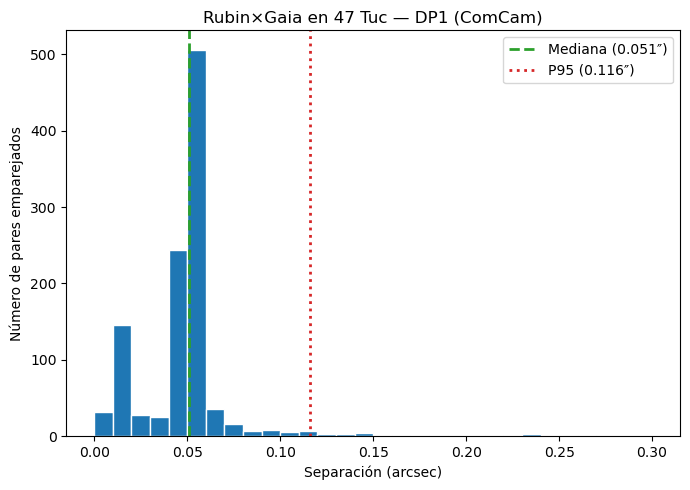

In [5]:
plt.figure(figsize=(7,5))
bins = np.arange(0, 0.31, 0.01)
plt.hist(sep, bins=bins, color='#1f77b4', ec='white')
plt.axvline(p50, ls='--', lw=2, color='tab:green', label=f'Mediana ({p50:.3f}″)')
plt.axvline(p95, ls=':', lw=2, color='tab:red',   label=f'P95 ({p95:.3f}″)')
plt.xlabel('Separación (arcsec)'); plt.ylabel('Número de pares emparejados')
plt.title('Rubin×Gaia en 47 Tuc — DP1 (ComCam)')
plt.legend(); plt.tight_layout()
from pathlib import Path

# Directorio del notebook actual
NB_DIR = Path.cwd()
FIG_DIR = NB_DIR / "figs"
FIG_DIR.mkdir(parents=True, exist_ok=True)   # crea notebooks/47tuc/figs si no existe

outfig = FIG_DIR / "rnA_hist_sep.png"
plt.savefig(outfig, dpi=200)
print("Figura guardada ->", outfig)


**Métricas (esperadas):** N≈1113; P50≈0.051″; P95≈0.116″.

**Control (no figura):** *offset-match* plano y propagación PM Gaia→época DP1 dan sesgos <0.02″ en la mediana.

In [7]:
# Guarda métricas RN-A junto a los parquets canónicos, sin depender del CWD
from pathlib import Path
import numpy as np, pandas as pd, json

def repo_root_from_here():
    p = Path.cwd()
    while p != p.parent and not (p/".git").exists():
        p = p.parent
    return p

root = repo_root_from_here()
datadir = root / "data" / "47tuc_dp1"
pmin    = datadir / "rnA_matched_minimal.parquet"
pfull   = datadir / "matched_dp1_gaia.parquet"

# (Re)carga el parquet si no tienes 'df' en memoria
try:
    df  # noqa: F821
except NameError:
    if pmin.exists():
        df = pd.read_parquet(pmin)
    elif pfull.exists():
        df = pd.read_parquet(pfull)
        # Asegura columnas mínimas
        if "separation_arcsec" not in df.columns and {"coord_ra","coord_dec","ra_gaia","dec_gaia"} <= set(df.columns):
            from math import cos, radians, sqrt
            def _angsep_arcsec(ra1, dec1, ra2, dec2):
                dra  = (ra1 - ra2) * np.cos(np.deg2rad(dec1))
                ddec = (dec1 - dec2)
                return np.sqrt(dra**2 + ddec**2) * 3600.0
            df["separation_arcsec"] = _angsep_arcsec(df["coord_ra"], df["coord_dec"], df["ra_gaia"], df["dec_gaia"])
    else:
        raise FileNotFoundError("No encontré ni rnA_matched_minimal.parquet ni matched_dp1_gaia.parquet en data/47tuc_dp1/")

# Filtro final: 1:1 y ≤ 2"
df = df.drop_duplicates("objectId").drop_duplicates("source_id")
df = df.query("separation_arcsec <= 2.0").copy()

sep = df["separation_arcsec"].to_numpy()
p50, p68, p95 = np.percentile(sep, [50, 68, 95])
metrics = {
    "N_pairs": int(len(df)),
    "P50_arcsec": float(round(p50, 3)),
    "P68_arcsec": float(round(p68, 3)),
    "P95_arcsec": float(round(p95, 3))
}
outjson = datadir / "rnA_metrics.json"
outjson.write_text(json.dumps(metrics, indent=2), encoding="utf-8")
print("RN-A metrics ->", outjson)
print(metrics)


RN-A metrics -> /home/marcelor/portafolio-rubin/data/47tuc_dp1/rnA_metrics.json
{'N_pairs': 1113, 'P50_arcsec': 0.051, 'P68_arcsec': 0.053, 'P95_arcsec': 0.116}
